<a href="https://colab.research.google.com/github/Resource-Efficiency-Collective/coding-tutorials/blob/main/L4_Drawing_Sankeys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L4 Drawing Sankey Diagrams - Workshop

This workshop is broken down into 3 parts to get you familiar with building Sankey diagrams:
- Part 1 - SankeyMATIC online Sankey tool
- Part 2 - `floweaver` tutorials for Sankeys in Python
- Part 3 - Practice exercises



## 1 - SankeyMATIC (~20 mins)

SankeyMATICis an online Sankey drawing software, which  builds on the open source tool D3.js and its Sankey library. SankeyMATIC unlocks the capabilities of the D3 Sankey tool for anyone to use.



1.   Open SankeyMATIC in a web browser: http://sankeymatic.com
  -  Read the home page, and spend some time playing with the example in the "Build a Sankey Diagram" tab, including understanding what each of the functionally options does.
2.   Run the following cells to first import the example data used throughout this notebook and second download a file called `us-energy-consumption.csv`. This will appear in your Downloads folder, please then open this file.



In [ ]:
# @markdown Run this cell once to load data
%%capture
import os
from google.colab import files

# Function to download and unzip the examples file from Google Drive
def download_and_unzip_from_google_drive(file_id = '1qriY29v7eKJIs07UxAw5RlJirfwuLnyP', destination_folder = 'example_data'):
    if os.path.exists(destination_folder):
      print('zip file already downloaded. If you want to reload then please delete the example_data folder.')
      return

    else:
      download_url = f"https://drive.google.com/uc?id={file_id}"
      !wget -O temp.zip $download_url

      os.makedirs(destination_folder)
      !unzip temp.zip -d $destination_folder

      os.remove("temp.zip")

download_and_unzip_from_google_drive()


In [ ]:
"""Download us-energy-consumption file"""
files.download('example_data/us-energy-consumption.csv')

3.   In the `us-energy-consumption.csv` file convert the data into the form "source [value] target" required for SankeyMATIC. (Hint: Consider the & function in Excel. CONCATENATE also works but is not best practice.)
4.   Paste the data into SankeyMATIC and "Preview". This example is based on the [Sankey diagrams of US energy consumption from the Lawrence Livermore National Laboratory](https://flowcharts.llnl.gov/content/assets/images/energy/us/Energy_US_2019.png). Play with the functions in SankeyMATIC, including dragging the flows, to get it to look like the LLNL example. Take a screen shot.  
5. Make a note of some of the frustrations you have using this online tool.  



---



##2 - Using `floweaver` (~30 mins)

floWeaver was developed by Dr Richard Lupton, while he was a Research Associate at Cambridge. The software is designed for researchers who need much more flexibility and control when drawing Sankey diagrams.  


###A - Floweaver basics
Let's get you up and running with some basic Sankeys.

Run these first two cells to install the package and set up the notebook to display Sankeys.

In [ ]:
%%capture
"""Installation and downloads"""
# Install floweaver and display widget packages
%pip install floweaver ipysankeywidget

# Import necessary packages
import pandas as pd
from floweaver import *
from ipysankeywidget import SankeyWidget

In [ ]:
"""Display setup"""
# Enable widget display for Sankeys in Colab
from google.colab import output
output.enable_custom_widget_manager()

Let's start by considering a simple dataset. Imagine we have some farms, which grow apples and bananas to sell to a few different customers. We can describe the *flow* of fruit from the farms (the *source* of the flow) to the customers (the *target* of the flow).

In [ ]:
"""Import data using pandas"""
flows = pd.read_csv('example_data/simple_fruit_sales.csv')
display(flows)

Drawn directly as a Sankey diagram, this data would look something like this:

In [ ]:
"""Let's draw our first Sankey!"""
SankeyWidget(links=flows.to_dict('records'))

But you don't always want a direct correspondence between the flows in your data and the links that you see in the Sankey diagram. For example:

* Farms 4, 5 and 6 are all pretty small, and to make the diagram clearer we might want to group them in an "other" category.
* The flows of apples are mixed in with the flows of bananas -- we might want to group the kinds of fruit together to make them easier to compare
* We might want to group farms or customers based on some other attributes -- to see difference between genders, locations, or organic/non-organic farms, say.

This first part shows how to use `floweaver` to do some of these for this simple example, in the simplest possible way. Later tutorials will show how to use it on real data, and more efficient ways to do the same things.

#### Basic diagram

Let's start with the first example: grouping farms 4, 5 and 6 into an "other" category. `floweaver` works by setting up a "Sankey diagram definition" which describes the structure of the diagram we want to see. In this case, we need to set up some groups:

In [ ]:
"""Define diagram processes"""
# Set the default size to fit the documentation better.
size = dict(width=570, height=300)

# Defining our sources and targets as nodes
nodes = {
    'farms': ProcessGroup(['farm1', 'farm2', 'farm3',
                           'farm4', 'farm5', 'farm6']),
    'customers': ProcessGroup(['James', 'Mary', 'Fred', 'Susan']),
}

We need to describe roughly how these groups should be placed in the final diagram by defining an "ordering" -- a list of vertical slices, each containing a list of node ids:

In [ ]:
"""Define order of processes in diagram"""
ordering = [
    ['farms'],       # put "farms" on the left...
    ['customers'],   # ... and "customers" on the right.
]

And we also need to say which connections should appear in the diagram (sometimes you don't want to actually see all the connections). This is called a "bundle" because it bundles up multiple flows -- in this case all of them.

In [ ]:
"""Define links between processes"""
bundles = [
    Bundle('farms', 'customers'),
]

Putting that together into a Sankey diagram definition (SDD) and applying it to the data gives this result:

In [ ]:
"""Let's see our grouped Sankey"""
sdd = SankeyDefinition(nodes, bundles, ordering)
weave(sdd, flows).to_widget(**size)

That's not very useful. What's happened? Every farm and every customer has been lumped together into one group. To get the picture we want -- like the first one, but with an "other" group containing farms 4, 5 and 6 -- we need to *partition* the groups:

In [ ]:
"""Let's partition the groups we've made"""
# The first argument is the dimension name and the second argument is a list of groups.
farms_with_other = Partition.Simple('process', [
    'farm1',  # the groups within the partition can be a single id...
    'farm2',
    'farm3',
    ('other', ['farm4', 'farm5', 'farm6']),   # ... or a group
])

# This is another partition.
customers_by_name = Partition.Simple('process', [
    'James', 'Mary', 'Fred', 'Susan'
])

# Update the ProcessGroup nodes to use the partitions
nodes['farms'].partition = farms_with_other
nodes['customers'].partition = customers_by_name

# New Sankey!
weave(sdd, flows).to_widget(**size)

That's better: now the farms are split up appropriately with an "other" category, and the customers are shown separately as well. We don't have to stop there -- what about showing sales to men and women?

In [ ]:
"""Different partitioning"""
# Group customers by gender
customers_by_gender = Partition.Simple('process', [
    ('Men', ['Fred', 'James']),
    ('Women', ['Susan', 'Mary']),
])

nodes['customers'].partition = customers_by_gender

weave(sdd, flows).to_widget(**size).auto_save_png('quickstart_example1.png')

> There is a better way of specifying this type of partition that doesn't involve hard-coding who's a man and who's a woman into the code -- see the later tutorial on using *dimension tables*.

#### Distinguishing flow types

These diagrams have lost sight of the kind of fruit that is actually being sold -- are the men buying apples, bananas or both from farm1? To show this we need to split up the flows in the diagram based on their *type*. Just like we split up the `ProcessGroups` by defining a partition of processes, we split up flows by defining a partition of flows.

(While we're at it let's choose some colours that look vaguely like apples and bananas)

In [ ]:
"""Partitioning the types column"""
fruits_by_type = Partition.Simple('type', ['apples', 'bananas'])

# Set the colours for the labels in the partition.
palette = {'apples': 'yellowgreen', 'bananas': 'gold'}

# New SDD with the flow_partition set
sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=fruits_by_type)
weave(sdd, flows, palette=palette).to_widget(**size)

As a last step, it would be nice to label which flows are apples and which are bananas. One way to do this would be to use a legend next to the diagram, or to put labels on every flow. Here, we'll add a new layer in the middle of the diagram which temporarily groups together the different fruit types on their way from the farms to the customers. This temporary/additional grouping point is called a *waypoint*.

To add a waypoint, we need to do three things:

1. Define it as a node
2. Position it in the ordering (between `farms` and `customers`)
3. Add it to the bundle

In [ ]:
"""Set up a midpoint to visualise types"""
# 1. Define a new waypoint node
nodes['waypoint'] = Waypoint()

# 2. Update the ordering to show where the waypoint goes: in the middle
ordering = [
    ['farms'],
    ['waypoint'],
    ['customers'],
]

# 3. Update the bundle definition to send the flows via the waypoint
bundles = [
    Bundle('farms', 'customers', waypoints=['waypoint']),
]

# Update the SDD with the new nodes, ordering & bundles.
sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=fruits_by_type)
weave(sdd, flows, palette=palette).to_widget(**size)

That's not yet very useful. Just like above, the default for Waypoints is to group everything togeter. We need to set a partition on the waypoint to split apart apples and bananas:

In [ ]:
# Redefine the waypoint with a partition (same one defined above)
nodes['waypoint'] = Waypoint(fruits_by_type)

weave(sdd, flows, palette=palette).to_widget(**size)

#### Summary

This has demonstrated the basic usage of `floweaver`: defining `ProcessGroup`s, `Waypoint`s, `Partition`s, and `Bundle`s. If you like, why not go back and try out some different ways to present the data? Here are some suggestions:

1. Farms 1, 3 and 5 are organic. Can you change the farm Partition to show two groups, organic and non-organic?
2. What happens if you remove `"farm1"` from the original definition of the `farms` `ProcessGroup`? (Hint: those apples that James and Mary are eating have to come from somewhere -- so they are shown as coming from "elsewhere". See part C on system-boundaries.

###B - Floweaver tutorials
You've now learnt the basics of Floweaver. Follow through the [floweaver_tutorials](https://colab.research.google.com/github/Resource-Efficiency-Collective/coding-tutorials/blob/main/floweaver_tutorials.ipynb#scrollTo=pG2YiL2mr5qw) notebook to learn about dimension tables, system boundaries and colour scales for our Sankeys.

### C - Some recipes for common flows
To see some examples of Sankey usage in Floweaver step through the [sankey_recipes](https://colab.research.google.com/github/Resource-Efficiency-Collective/coding-tutorials/blob/main/sankey_recipes.ipynb) notebook.

##3 - Sankey exercises (~50 mins)

Let's put some of our learning in to practice and get coding our own Sankeys!


###A - IEA Sankey
In this final section, we want to create an energy consumption Sankey diagram.  You might want to choose a country that you are analysing for Assignment 1. The [energy_consumption](https://colab.research.google.com/github/Resource-Efficiency-Collective/coding-tutorials/blob/main/energy_consumption.ipynb) notebook contains an example of a Sankey diagram for US energy consumption. Please open it up and follow the steps to create a version for your country.

Here's an attempt at a New Zealand energy Sankey:

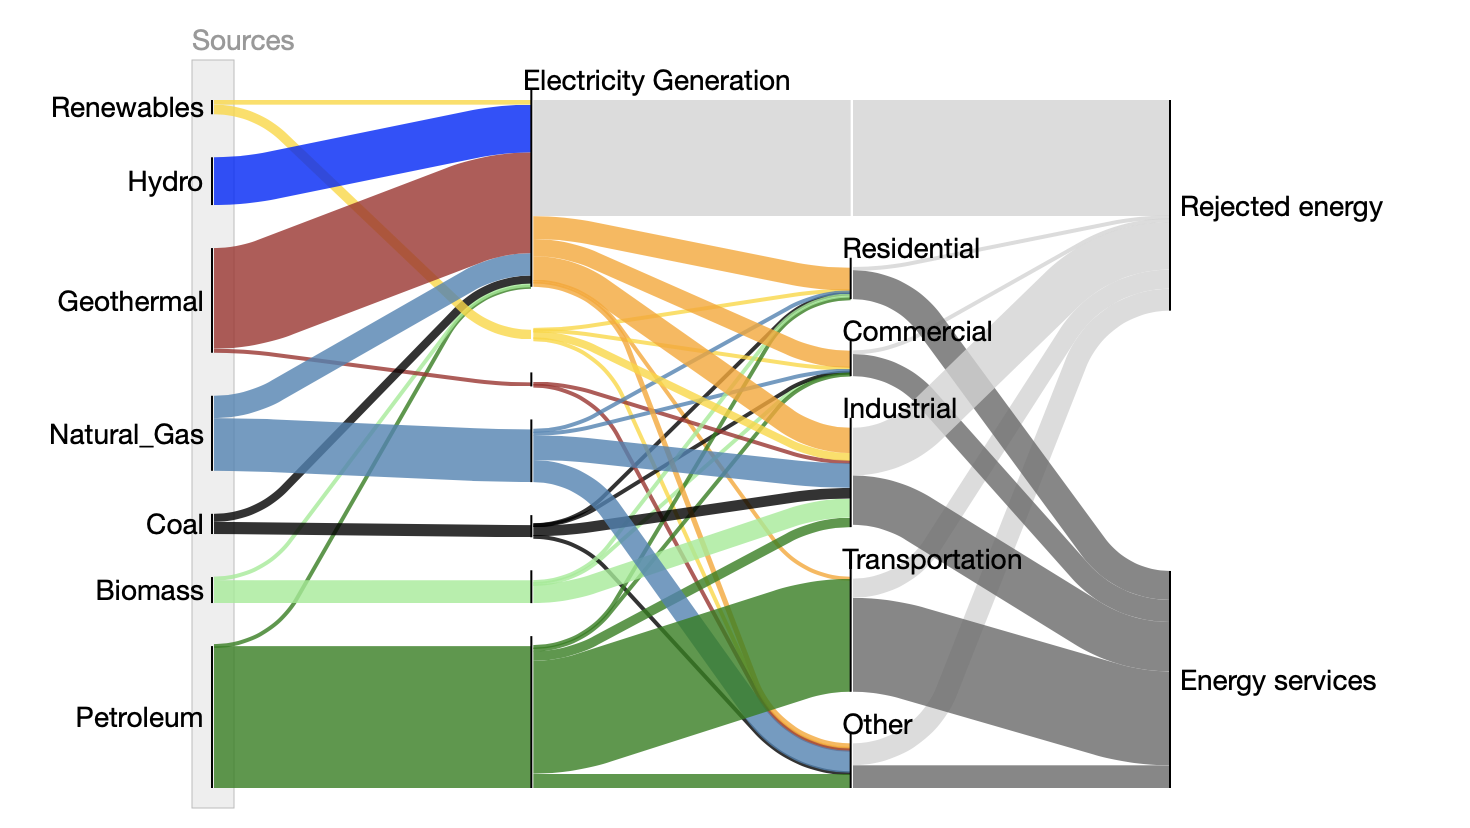


###B - US Steel imports
If you've managed to get through the whole IEA exercise and created a picture-perfect Sankey that refreshes for any country in a single click, well done! Now consider US Steel import data available [available here](https://www.trade.gov/media/4964). Go back in to your completed version of the [energy_consumption](https://colab.research.google.com/github/Resource-Efficiency-Collective/coding-tutorials/blob/main/energy_consumption.ipynb) notebook and try to use the same functions as you made for the IEA data. They will need to be adjusted to both cater both for this dataset and still work with the IEA data.

If you manage to finish up this part also, then very well done! Upload your results to your GitHub and let one of the supervisors know so we can come and see how you've written!